# Supervised Learning : NBA Shots Log Data (DS-SF-25 | Final Project)

## Importing and Reading Data

In [79]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model, metrics
from sklearn import neighbors, metrics, grid_search, cross_validation
from sklearn import tree, ensemble, metrics, cross_validation, externals
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
def read_dataset(x):
    return pd.read_csv(os.path.join('..', 'datasets', x))
train_2_df = read_dataset('train_2pts.csv')
test_2_df = read_dataset('test_2pts.csv')

In [3]:
# dropping the index from the from the prior data read for EDA purpose.
train_2_df = train_2_df.drop('Unnamed: 0',1)
test_2_df = test_2_df.drop('Unnamed: 0',1)

In [4]:
train_2_df.head(2)

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,PTS,player_name,player_id,Month,location_t,GAME_CLOCK_t,SHOT_CLOCK_t,Catch&Shot,SHOT_DISTANCE,CLOSEST_DEFENDER_DISTANE
0,21400530,"JAN 07, 2015 - DEN vs. ORL",H,W,3,7,3,9:51,8.6,0,...,2,jusuf nurkic,203994,JAN,0,2031.0,2,1,6,4
1,21400325,"DEC 10, 2014 - MIA @ DEN",A,L,-20,5,2,11:12,12.9,2,...,0,dwayne wade,2548,DEC,1,1392.0,3,0,8,2


In [5]:
# Correlation table for significant features
train_2_df[['SHOT_NUMBER','GAME_CLOCK_t','Catch&Shot','SHOT_CLOCK','SHOT_DIST','CLOSE_DEF_DIST','FGM']].corr()

,SHOT_NUMBER,GAME_CLOCK_t,Catch&Shot,SHOT_CLOCK,SHOT_DIST,CLOSE_DEF_DIST,FGM
SHOT_NUMBER,1.000000,0.584055,-0.081121,-0.039647,0.008015,-0.019667,-0.004765
GAME_CLOCK_t,0.584055,1.000000,-0.021939,-0.044220,-0.002361,-0.017509,-0.007866
Catch&Shot,-0.081121,-0.021939,1.000000,0.171608,-0.035475,0.151634,0.095314
SHOT_CLOCK,-0.039647,-0.044220,0.171608,1.000000,-0.250994,0.013477,0.117137
SHOT_DIST,0.008015,-0.002361,-0.035475,-0.250994,1.000000,0.456704,-0.166451
CLOSE_DEF_DIST,-0.019667,-0.017509,0.151634,0.013477,0.456704,1.000000,0.055166
FGM,-0.004765,-0.007866,0.095314,0.117137,-0.166451,0.055166,1.000000


In [6]:
corr=train_2_df[['SHOT_NUMBER','GAME_CLOCK_t','Catch&Shot','SHOT_CLOCK','SHOT_DIST','CLOSE_DEF_DIST','FGM']].corr()

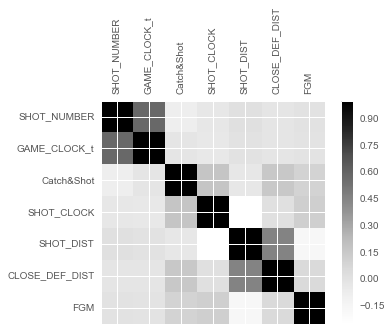

In [7]:
# Correlation heatmap
list(corr.columns)
figure = plt.figure()
subplot = figure.add_subplot(1, 1, 1)
figure.colorbar(subplot.matshow(corr))
subplot.set_xticklabels([None] + list(corr.columns), rotation = 90)
subplot.set_yticklabels([None] + list(corr.columns))

## Modeling

In [8]:
train_y = train_2_df.FGM
test_y = test_2_df.FGM

#### Guessing the Majority Class

Train Result

In [9]:
# predict all missed shots
train_2_df['model_1_y_hat']=0

In [10]:
#Confusion Matrix
pd.crosstab(train_y, train_2_df.model_1_y_hat, rownames = ['True Class'], colnames = ['Hypothesized Class'])

Hypothesized Class,0
True Class,
0,27647
1,26558


In [11]:
#Null accuracy rate
27647./(26558+27647)

0.5100451987824002

Test Result

In [12]:
test_2_df['model_1_y_hat']=0

In [13]:
pd.crosstab(test_y, test_2_df.model_1_y_hat, rownames = ['True Class'], colnames = ['Hypothesized Class'])

Hypothesized Class,0
True Class,
0,18519
1,17822


In [14]:
#Null accuracy rate
18519./(17822+18519)

0.5095897196004513

#### Logistic Regression

In [15]:
#Logistic 1: all significant features
train_X = train_2_df[['SHOT_NUMBER','GAME_CLOCK_t','Catch&Shot','SHOT_CLOCK','SHOT_DIST','CLOSE_DEF_DIST']]

In [16]:
logit = linear_model.LogisticRegression().\
    fit(train_X, train_y)

In [17]:
print logit.coef_
print logit.intercept_

[[  5.64305334e-03  -2.33335286e-05   2.18470459e-01   1.81001294e-02
   -7.36275650e-02   1.64091028e-01]]
[-0.21519753]


Train result

In [18]:
# Confusion matrix
pd.crosstab(train_y, logit.predict(train_X), rownames = ['True Class'], colnames = ['Hypothesized Class'])

Hypothesized Class,0,1
True Class,,
0,17731,9916
1,11697,14861


In [19]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks)
    plt.yticks(tick_marks)
    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label')

In [20]:
def confusion_matrix_cal(cm):
    print "Accuracy =", metrics.accuracy_score(train_y,logit.predict(train_X))
    print "True positive rate =", float(cm[1][1])/(cm[1][0]+cm[1][1])
    print "False positive rate =", float(cm[0][1])/(cm[0][1]+cm[0][0])
    print "Specificity =", float(cm[0][0])/(cm[0][0]+cm[0][1])
    print "Precision", float(cm[1][1])/(cm[0][1]+cm[1][1])
    print "Improvement compared to null error rate =", metrics.accuracy_score(train_y,logit.predict(train_X))- 27647./(26558+27647)

Normalized confusion matrix
[[ 0.64133541  0.35866459]
 [ 0.44043226  0.55956774]]


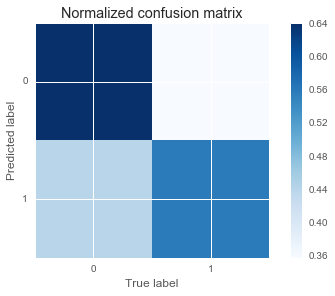

In [21]:
cm = metrics.confusion_matrix(train_y,logit.predict(train_X))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()

In [22]:
#Confusion matrix metrics:
confusion_matrix_cal(cm)

Accuracy = 0.6012729453
True positive rate = 0.559567738535
False positive rate = 0.358664592903
Specificity = 0.641335407097
Precision 0.599790127941
Improvement compared to null error rate = 0.0912277465178


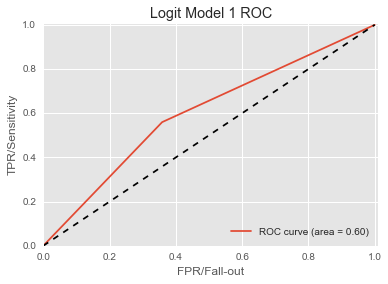

In [23]:
#ROC
fpr, tpr, thresholds = metrics.roc_curve(train_y, logit.predict(train_X))

plt.figure()
plt.plot(fpr, tpr, label = 'ROC curve (area = %0.2f)' % metrics.auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1.01])
plt.ylim([0, 1.01])
plt.xlabel('FPR/Fall-out')
plt.ylabel('TPR/Sensitivity')
plt.title("Logit Model 1 ROC")
plt.legend(loc = 'lower right')
plt.show()

In [24]:
#Logistic 2: Only Shot Distance, Closest Defender and Catch&Shot
train_X = train_2_df[['Catch&Shot','SHOT_DIST','CLOSE_DEF_DIST']]

In [25]:
logit = linear_model.LogisticRegression().\
    fit(train_X, train_y)

In [26]:
print logit.coef_
print logit.intercept_

[[ 0.24537972 -0.07823159  0.16968909]]
[ 0.02946337]


In [27]:
# Accuracy for 
logit.score(train_X, train_y)

0.60011069089567382

In [28]:
pd.crosstab(train_y, logit.predict(train_X), rownames = ['Hypothesized Class'], colnames = ['True Class'])

True Class,0,1
Hypothesized Class,,
0,17523,10124
1,11552,15006


Normalized confusion matrix
[[ 0.63381199  0.36618801]
 [ 0.43497251  0.56502749]]


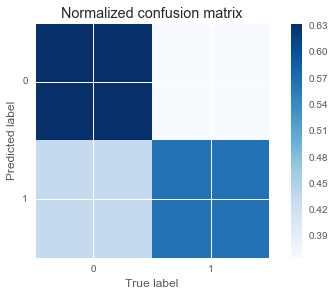

In [29]:
cm = metrics.confusion_matrix(train_y,logit.predict(train_X))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()

In [30]:
confusion_matrix_cal(cm)

Accuracy = 0.600110690896
True positive rate = 0.56502748701
False positive rate = 0.366188013166
Specificity = 0.633811986834
Precision 0.597134898528
Improvement compared to null error rate = 0.0900654921133


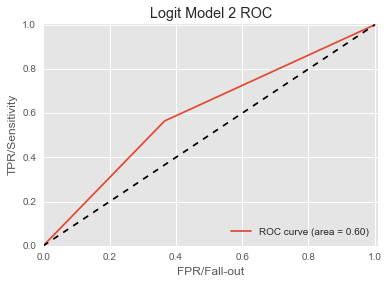

In [31]:
#ROC
fpr, tpr, thresholds = metrics.roc_curve(train_y, logit.predict(train_X))

plt.figure()
plt.plot(fpr, tpr, label = 'ROC curve (area = %0.2f)' % metrics.auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1.01])
plt.ylim([0, 1.01])
plt.xlabel('FPR/Fall-out')
plt.ylabel('TPR/Sensitivity')
plt.title("Logit Model 2 ROC")
plt.legend(loc = 'lower right')
plt.show()

In [32]:
#Logistic 3: Only Shot Distance
train_X = train_2_df[['SHOT_DIST']]

In [33]:
logit = linear_model.LogisticRegression().\
    fit(train_X, train_y)

In [34]:
print logit.coef_
print logit.intercept_

[[-0.05018763]]
[ 0.43652975]


In [35]:
pd.crosstab(train_y, logit.predict(train_X), rownames = ['Hypothesized Class'], colnames = ['True Class'])

True Class,0,1
Hypothesized Class,,
0,14303,13344
1,9755,16803


Normalized confusion matrix
[[ 0.51734365  0.48265635]
 [ 0.36730929  0.63269071]]


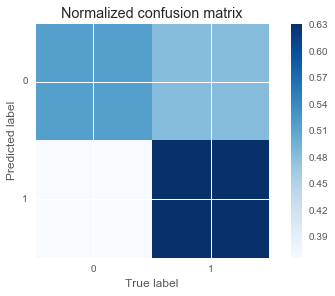

In [36]:
cm = metrics.confusion_matrix(train_y,logit.predict(train_X))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()

In [37]:
confusion_matrix_cal(cm)

Accuracy = 0.573858500138
True positive rate = 0.632690714662
False positive rate = 0.482656346077
Specificity = 0.517343653923
Precision 0.557368892427
Improvement compared to null error rate = 0.063813301356


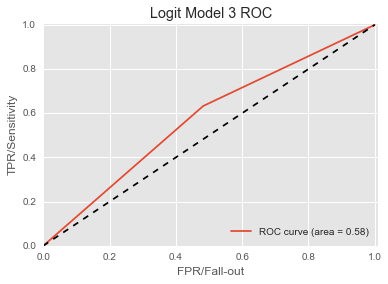

In [38]:
#ROC
fpr, tpr, thresholds = metrics.roc_curve(train_y, logit.predict(train_X))

plt.figure()
plt.plot(fpr, tpr, label = 'ROC curve (area = %0.2f)' % metrics.auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1.01])
plt.ylim([0, 1.01])
plt.xlabel('FPR/Fall-out')
plt.ylabel('TPR/Sensitivity')
plt.title("Logit Model 3 ROC")
plt.legend(loc = 'lower right')
plt.show()

In [39]:
#Logistic 4: Only Shot Distance and Catch%Shot
train_X = train_2_df[['SHOT_DIST','Catch&Shot']]

In [40]:
logit = linear_model.LogisticRegression().\
    fit(train_X, train_y)

In [41]:
print logit.coef_
print logit.intercept_

[[-0.04958341  0.37679846]]
[ 0.28197753]


In [42]:
# Accuracy for 
logit.score(train_X, train_y)

0.58963195277188452

In [43]:
pd.crosstab(train_y, logit.predict(train_X), rownames = ['Hypothesized Class'], colnames = ['True Class'])

True Class,0,1
Hypothesized Class,,
0,17317,10330
1,11914,14644


Normalized confusion matrix
[[ 0.62636091  0.37363909]
 [ 0.44860306  0.55139694]]


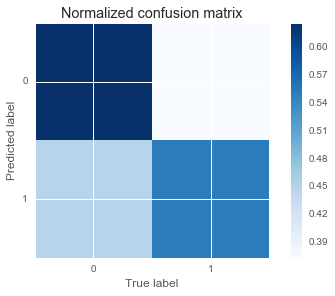

In [44]:
cm = metrics.confusion_matrix(train_y,logit.predict(train_X))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()

In [45]:
confusion_matrix_cal(cm)

Accuracy = 0.589631952772
True positive rate = 0.551396942541
False positive rate = 0.373639092849
Specificity = 0.626360907151
Precision 0.586369824618
Improvement compared to null error rate = 0.0795867539895


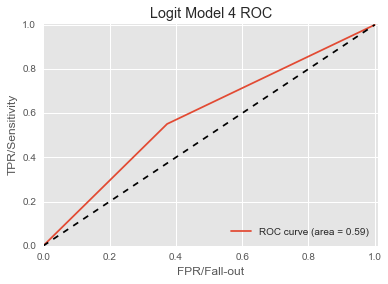

In [46]:
#ROC
fpr, tpr, thresholds = metrics.roc_curve(train_y, logit.predict(train_X))

plt.figure()
plt.plot(fpr, tpr, label = 'ROC curve (area = %0.2f)' % metrics.auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1.01])
plt.ylim([0, 1.01])
plt.xlabel('FPR/Fall-out')
plt.ylabel('TPR/Sensitivity')
plt.title("Logit Model 4 ROC")
plt.legend(loc = 'lower right')
plt.show()

In [47]:
#Logistic 4: Only Shot Distance and Catch%Shot
train_X = train_2_df[['SHOT_DIST','CLOSE_DEF_DIST']]

In [48]:
logit = linear_model.LogisticRegression().\
    fit(train_X, train_y)

In [49]:
print logit.coef_
print logit.intercept_

[[-0.08134148  0.18537128]]
[ 0.10358656]


In [50]:
# Accuracy for 
logit.score(train_X, train_y)

0.59446545521630845

In [51]:
pd.crosstab(train_y, logit.predict(train_X), rownames = ['Hypothesized Class'], colnames = ['True Class'])

True Class,0,1
Hypothesized Class,,
0,16906,10741
1,11241,15317


Normalized confusion matrix
[[ 0.61149492  0.38850508]
 [ 0.42326229  0.57673771]]


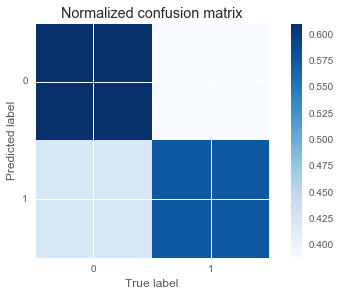

In [52]:
cm = metrics.confusion_matrix(train_y,logit.predict(train_X))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()

In [53]:
confusion_matrix_cal(cm)

Accuracy = 0.594465455216
True positive rate = 0.576737706153
False positive rate = 0.388505081926
Specificity = 0.611494918074
Precision 0.58780412925
Improvement compared to null error rate = 0.0844202564339


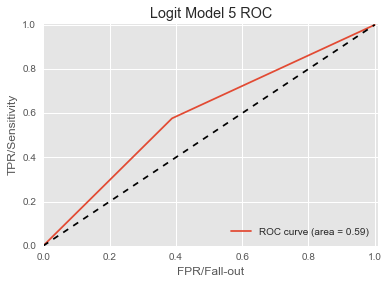

In [54]:
#ROC
fpr, tpr, thresholds = metrics.roc_curve(train_y, logit.predict(train_X))

plt.figure()
plt.plot(fpr, tpr, label = 'ROC curve (area = %0.2f)' % metrics.auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1.01])
plt.ylim([0, 1.01])
plt.xlabel('FPR/Fall-out')
plt.ylabel('TPR/Sensitivity')
plt.title("Logit Model 5 ROC")
plt.legend(loc = 'lower right')
plt.show()

#### Logistic Model Compare

Metrics| Logit_1 | Logit_2 | Logit_3 | Logit_4 | Logit_5
---|---|---
Accuracy | 0.6012729453	 | 0.600110690896 | 0.589631952772 |0.589631952772| 0.594465455216
True positive rate | 0.559567738535 | 0.56502748701 |0.632690714662|0.551396942541|0.576737706153
False positive rate | 0.358664592903 | 0.366188013166 |0.482656346077|0.373639092849|0.388505081926
Specificity | 0.641335407097 | 0.633811986834 |0.517343653923|0.626360907151|0.611494918074
Precision | 0.599790127941 | 0.597134898528 |0.557368892427|0.586369824618|0.58780412925
Improvement | 0.0912277465178 | 0.0900654921133 |0.063813301356|0.0795867539895|0.0844202564339

From comparing Logistic Model 1 and 2, the improvement of including all variables are not significant. For simplicity, logistic model 2 performed is better since it only includes the 3 most significant variables. When compared logistic model 2 to others (3, 4 and 5), it kind of depends on which metrics we want to optimize.

#### KNN

In [55]:
KNN_train_df = train_2_df[['Catch&Shot','SHOT_DIST','CLOSE_DEF_DIST']]

In [56]:
KNN_test_df = test_2_df[['Catch&Shot','SHOT_DIST','CLOSE_DEF_DIST']]

In [57]:
# Variable Scaling
def variable_scale(x):
    s = pd.Series(data, index=index)
    for n in len(x):
        (x[n]-x.min())/(x.max()-x.min())
        

In [58]:
# Scaling for both training and testingf
for n in range(1,3):
    KNN_train_df[KNN_train_df.columns[n]] = \
        (KNN_train_df[KNN_train_df.columns[n]]-KNN_train_df[KNN_train_df.columns[n]].min())\
        /(KNN_train_df[KNN_train_df.columns[n]].max()-KNN_train_df[KNN_train_df.columns[n]].min())
for n in range(1,3):
    KNN_test_df[KNN_train_df.columns[n]] = \
        (KNN_train_df[KNN_train_df.columns[n]]-KNN_train_df[KNN_train_df.columns[n]].min())\
        /(KNN_train_df[KNN_train_df.columns[n]].max()-KNN_train_df[KNN_train_df.columns[n]].min())    

/Users/gyzhang328/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/gyzhang328/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [59]:
KNN_test_df.head(2)

,Catch&Shot,SHOT_DIST,CLOSE_DEF_DIST
0,0,0.198312,0.062382
1,0,0.282700,0.032136


In [60]:
KNN_train_df.head(2)

,Catch&Shot,SHOT_DIST,CLOSE_DEF_DIST
0,1,0.198312,0.062382
1,0,0.282700,0.032136


In [61]:
train_X = KNN_train_df
KNN_model = neighbors.KNeighborsClassifier(n_neighbors = 3, weights = 'uniform')
KNN_model.fit(train_X, train_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [64]:
KNN_model.score(train_X, train_y)

0.70879070196476335

In [65]:
k = range(1, 50)

score_df = pd.DataFrame({'k': k})

models = score_df\
    .apply(lambda row: neighbors.KNeighborsClassifier(n_neighbors = row['k']).fit(train_X, train_y), axis = 1)

models

score_df['Score'] = models.map(lambda model: model.score(train_X, train_y))

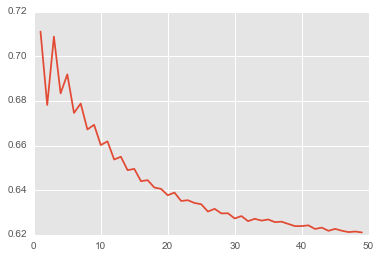

In [66]:
plt.plot(score_df.k, score_df.Score)

In [67]:
score_df[score_df.Score ==score_df.Score.max()]

,k,Score
0,1,0.711041


In [68]:
train_X = KNN_train_df
KNN_model = neighbors.KNeighborsClassifier(n_neighbors = 10, weights = 'distance')
KNN_model.fit(train_X, train_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='distance')

In [69]:
k = range(1, 50)

score_df = pd.DataFrame({'k': k})

models = score_df.\
    apply(lambda row: neighbors.KNeighborsClassifier(n_neighbors = row['k'], weights = 'distance').fit(train_X, train_y), axis = 1)

models

score_df['Score'] = models.map(lambda model: model.score(train_X, train_y))

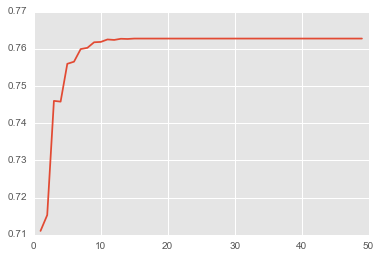

In [70]:
plt.plot(score_df.k, score_df.Score)

In [71]:
score_df[score_df.Score ==score_df.Score.max()].min()

k        15.000000
Score     0.762753
dtype: float64

In [76]:
KNN_model = neighbors.KNeighborsClassifier(n_neighbors = 15, weights = 'distance')
KNN_model.fit(train_X, train_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='distance')

KNN Summary: Seems like the best KNN model is k=1 for uniform model and k=15 for distance weighted model.

#### Random Forest

In [88]:
train_X =  train_2_df[['SHOT_NUMBER','GAME_CLOCK_t','Catch&Shot','SHOT_CLOCK','SHOT_DIST','CLOSE_DEF_DIST']]

In [89]:
train_X.head(2)

,SHOT_NUMBER,GAME_CLOCK_t,Catch&Shot,SHOT_CLOCK,SHOT_DIST,CLOSE_DEF_DIST
0,7,2031.0,1,8.6,4.7,3.3
1,5,1392.0,0,12.9,6.7,1.7


In [94]:
# 10K trees
random_forest_10K = ensemble.RandomForestClassifier(n_estimators = 10000,
        max_features = 4,
        min_samples_leaf = 5,
        oob_score = True,
        random_state = 0).\
    fit(train_X, train_y)

In [95]:
random_forest.oob_score_

0.58754727423669406

In [97]:
cross_validation.cross_val_score(random_forest, train_X, train_y, cv = 10).mean()

KeyboardInterrupt: 